### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


### Dataset Loader

In [24]:
class FacadesDataset(Dataset):
    def __init__(self, root_dir_A, transform=None):
        self.root_dir_A = root_dir_A  # Directory for input images (label maps)
        #self.root_dir_B = root_dir_B  # Directory for target images (facades)
        self.transform = transform
        # Get list of image paths from both directories
        self.image_paths_A = sorted([os.path.join(root_dir_A, img) for img in os.listdir(root_dir_A) if img.endswith('.jpg')])
        self.image_paths_B = sorted([os.path.join(root_dir_A, img) for img in os.listdir(root_dir_A) if img.endswith('.png')])

        # Ensure the number of images match
        assert len(self.image_paths_A) == len(self.image_paths_B), "Mismatch in number of images between A and B directories"
        print(f"Found {len(self.image_paths_A)} paired images in {root_dir_A} and {root_dir_A}")

    def __len__(self):
        return len(self.image_paths_A)

    def __getitem__(self, idx):
        # Load input (label map) and target (facade) images
        input_image = Image.open(self.image_paths_A[idx]).convert('RGB')
        target_image = Image.open(self.image_paths_B[idx]).convert('RGB')

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

In [25]:
class FacadesInferenceDataset(Dataset):
    def __init__(self, root_dir_A, transform=None):
        self.root_dir_A = root_dir_A  # Directory for input images (label maps)
        #self.root_dir_B = root_dir_B  # Directory for target images (facades)
        self.transform = transform
        # Get list of image paths from both directories
        self.image_paths_A = sorted([os.path.join(root_dir_A, img) for img in os.listdir(root_dir_A) if img.endswith('.jpg')])
        #self.image_paths_B = sorted([os.path.join(root_dir_B, img) for img in os.listdir(root_dir_B) if img.endswith('.jpg')])

        # Ensure the number of images match
        #assert len(self.image_paths_A) == len(self.image_paths_B), "Mismatch in number of images between A and B directories"
        print(f"Found {len(self.image_paths_A)} in {root_dir_A}")

    def __len__(self):
        return len(self.image_paths_A)

    def __getitem__(self, idx):
        # Load input (label map) and target (facade) images
        input_image = Image.open(self.image_paths_A[idx]).convert('RGB')
        #target_image = Image.open(self.image_paths_B[idx]).convert('RGB')

        if self.transform:
            input_image = self.transform(input_image)
            #target_image = self.transform(target_image)

        return input_image

In [26]:
# Define transformations
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])
    print("Transformations defined: Resize to 256x256, ToTensor, Normalize to [-1, 1]")
    return transform
    

### Network Architectures

In [27]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.dec6 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.dec7 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec8 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)
        e8 = self.enc8(e7)

        d1 = self.dec1(e8)
        d1 = torch.cat([d1, e7], dim=1)
        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e6], dim=1)
        d3 = self.dec3(d2)
        d3 = torch.cat([d3, e5], dim=1)
        d4 = self.dec4(d3)
        d4 = torch.cat([d4, e4], dim=1)
        d5 = self.dec5(d4)
        d5 = torch.cat([d5, e3], dim=1)
        d6 = self.dec6(d5)
        d6 = torch.cat([d6, e2], dim=1)
        d7 = self.dec7(d6)
        d7 = torch.cat([d7, e1], dim=1)
        d8 = self.dec8(d7)
        return d8


In [28]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x, y):
        input = torch.cat([x, y], dim=1)  # Concatenate input and target/generated image
        return self.model(input)


In [29]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Visualisation

In [57]:
# Function to display images
def show_images_two(input_img, target_img, title_first, title_second):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_img.permute(1, 2, 0) * 0.5 + 0.5)  # Denormalize
    ax[0].set_title(title_first)
    ax[1].imshow(target_img.permute(1, 2, 0) * 0.5 + 0.5)
    ax[1].set_title(title_second)
    plt.show()

# Function to display images
def show_images_three(input_img, generated_img, target_img, title_first, title_second, title_third):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(input_img.permute(1, 2, 0) * 0.5 + 0.5)  # Denormalize
    ax[0].set_title(title_first)
    ax[1].imshow(generated_img.permute(1, 2, 0) * 0.5 + 0.5)
    ax[1].set_title(title_second)
    ax[1].imshow(target_img.permute(1, 2, 0) * 0.5 + 0.5)
    ax[1].set_title(title_third)
    plt.show()

In [64]:
def generation_visualisation(data_loader, generator):
    # Test the generator with a sample input
    input_img, target_img = next(iter(train_loader))
    with torch.no_grad():
        sample_input = input_img.to(device)
        sample_output = generator(sample_input)
        print(f"Generator test output shape: {sample_output.shape}")

    show_images_two(input_img.cpu().squeeze(0), sample_output.cpu().squeeze(0), "Input Image", "Initial Generated Image")

In [48]:
def display_samples(data_loader, number):
    # Get and display a sample
    for i in range (number):
        input_img, target_img = next(iter(data_loader))
        print(f"\nDisplaying sample {i+1} from the dataset:")
        show_images_two(input_img[0], target_img[0], 'input image', 'target image')

In [33]:
#from google.colab import drive
#drive.mount('/content/drive')

### Generator and Discriminator Initialisation

In [34]:
# Initialize the generator
def get_generator():
    generator = UNetGenerator().to(device)
    print("U-Net Generator defined and moved to GPU")
    return generator

In [35]:
# Initialize the discriminator
def get_discriminator():
    discriminator = PatchGANDiscriminator().to(device)
    print("PatchGAN Discriminator defined and moved to GPU")
    return discriminator

In [36]:
def apply_weigts_init(generator, discriminator, weights_init):
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    print("Weights initialized with normal distribution (mean=0, std=0.02) for Conv layers and (mean=1, std=0.02) for BatchNorm")

In [55]:
# Loss functions
def get_BCEWithLogitsLoss():
    criterion_GAN = nn.BCEWithLogitsLoss()
    print("Loss functions defined: BCEWithLogitsLoss for GAN")
    return criterion_GAN
    
def get_L1Loss():
    criterion_L1 = nn.L1Loss()
    print("Loss functions defined: L1Loss for pixel-wise similarity")
    return criterion_L1

def get_optimiser_G():
    # Optimizer for generator
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    print("Optimizers defined: Adam with lr=0.0002, betas=(0.5, 0.999) for both Generator")
    return optimiser_G

def get_optimiser_D():
    # Optimiser for discriminator
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    print("Optimizers defined: Adam with lr=0.0002, betas=(0.5, 0.999) for Discriminator")
    return optimiser_D

### Training Setup and procedures

In [95]:
def model_learning(num_epochs, lambda_L1, train_loader, generator, discriminator, optimiser_G, optimiser_D):

    print (num_epochs)
    print (lambda_L1)
    print (train_loader)
    print (generator)
    print (discriminator)
    print (optimiser_G)
    print (optimiser_D)
    # Full training loop
    for epoch in range(num_epochs):
        for i, (input_img, target_img) in enumerate(train_loader):
            input_img = input_img.to(device)
            target_img = target_img.to(device)
    
            # Train Discriminator
            optimiser_D.zero_grad()
            pred_real = discriminator(input_img, target_img)
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
    
            generated_img = generator(input_img)
            pred_fake = discriminator(input_img, generated_img.detach())
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
    
            loss_D = (loss_D_real + loss_D_fake) / 2
            loss_D.backward()
            optimiser_D.step()
    
            # Train Generator
            optimiser_G.zero_grad()
            pred_fake = discriminator(input_img, generated_img)
            loss_G_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
            loss_G_L1 = criterion_L1(generated_img, target_img) * lambda_L1
            loss_G = loss_G_GAN + loss_G_L1
            loss_G.backward()
            optimiser_G.step()

            # Print progress every 100 steps
            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                      f"Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}, "
                      f"Loss_G_GAN: {loss_G_GAN.item():.4f}, Loss_G_L1: {loss_G_L1.item():.4f}")
        #visualise after each epoch using the last batch
        show_images_three(input_img.cpu().detach().squeeze(), generated_img.cpu().detach().squeeze(), 
                          target_img.cpu().detach().squeeze(), 'Input', 'Generated', 'Target')
    print("Training completed!")

In [96]:
def model_testing(test_loader, generator):
    generator.eval()

    # Initialize accumulators for metrics
    total_l1_loss = 0.0
    total_psnr = 0.0
    num_samples = 0

    # Disable gradient computation for testing
    with torch.no_grad():
        for i, (input_img, target_img) in enumerate(test_loader):
            # Move images to the device (e.g., GPU)
            input_img = input_img.to(device)
            target_img = target_img.to(device)
    
            # Generate image using the pix2pix generator
            generated_img = generator(input_img)
    
            # Compute L1 loss (on normalized images in [-1, 1])
            l1_loss = criterion_L1(generated_img, target_img)
            total_l1_loss += l1_loss.item()
    
            # Denormalize images to [0, 1] for PSNR calculation
            generated_img_denorm = ((generated_img + 1) / 2).clamp(0, 1)
            target_img_denorm = ((target_img + 1) / 2).clamp(0, 1)
    
            # Compute Mean Squared Error (MSE)
            mse = torch.mean((generated_img_denorm - target_img_denorm) ** 2)
    
            # Compute PSNR
            if mse > 0:
                psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
                total_psnr += psnr.item()
            else:
                total_psnr += 100  # Assign a high PSNR if MSE is zero (perfect match)
    
            num_samples += 1
    
            # Visualize the first 5 examples safely
            if i < 5:
                input_img_denorm = ((input_img + 1) / 2).clamp(0, 1)
                show_images_three(input_img_denorm.cpu().squeeze(0), generated_img_denorm.cpu().squeeze(0), target_img_denorm.cpu().squeeze(0), 'Input Label Map',  'Generated Facade', 'Real Facade')
                #for a in ax:
                #    a.axis('off')  # Hide axes for cleaner visuals
                
    # Compute average metrics
    avg_l1_loss = total_l1_loss / num_samples
    avg_psnr = total_psnr / num_samples
    
    # Print the results
    print(f"Test Results:")
    print(f"Average L1 Loss: {avg_l1_loss:.4f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    return avg_l1_loss, avg_psnr

In [97]:
def get_model_inference(inference_loader, generator):
    generator.eval()
    
    # Disable gradient computation for testing
    num_samples = 0
    with torch.no_grad():
        for i, (input_img) in enumerate(inference_loader):
            # Move images to the device (e.g., GPU)
            input_img = input_img.to(device)
            #target_img = target_img.to(device)
    
            # Generate image using the pix2pix generator
            generated_img = generator(input_img)
    
            # Denormalize images to [0, 1] for PSNR calculation
            generated_img_denorm = ((generated_img + 1) / 2).clamp(0, 1)
    
            num_samples += 1
    
            # Visualize the first 5 examples safely
            if i < 5:
                input_img_denorm = ((input_img + 1) / 2).clamp(0, 1)
                show_images_two(input_img_denorm.cpu().squeeze(0), generated_img_denorm.cpu().squeeze(0), 'Input Label Map', 'Generated Facade')  
                #for a in ax:
                #    a.axis('off')  # Hide axes for cleaner visuals
                #plt.show()


### Training data preparation

In [98]:
#data_path = "/content/drive/MyDrive/ColabNotebooks/Research/data/facade_dataset"
data_path = "/home/zia/Documents/research/data"

In [99]:
train_data_path = data_path + '/cmp_facade_base'

In [100]:
# Define the root directories for trainA and trainB (adjust based on Kaggle dataset path)
train_root_dir_A = train_data_path + '/base'
print(f"Dataset root directories set to: {train_root_dir_A} for (inputs) and (targets)")

Dataset root directories set to: /home/zia/Documents/research/data/cmp_facade_base/base for (inputs) and (targets)


In [101]:
# Load the dataset
train_dataset = FacadesDataset(root_dir_A=train_root_dir_A, transform=get_transform())
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
print(f"Dataset loaded with {len(train_dataset)} samples, DataLoader created with batch size 1")

Transformations defined: Resize to 256x256, ToTensor, Normalize to [-1, 1]
Found 378 paired images in /home/zia/Documents/research/data/cmp_facade_base/base and /home/zia/Documents/research/data/cmp_facade_base/base
Dataset loaded with 378 samples, DataLoader created with batch size 1



Displaying sample 1 from the dataset:


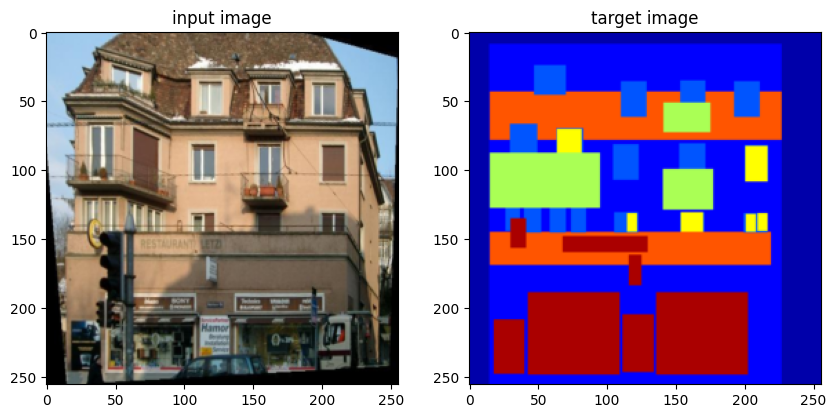


Displaying sample 2 from the dataset:


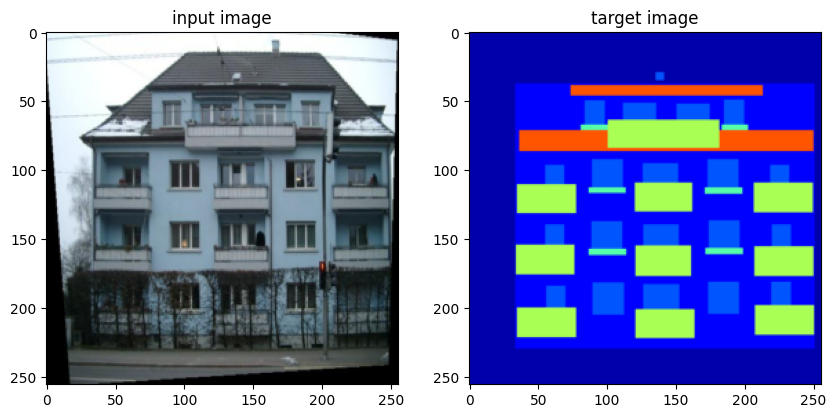


Displaying sample 3 from the dataset:


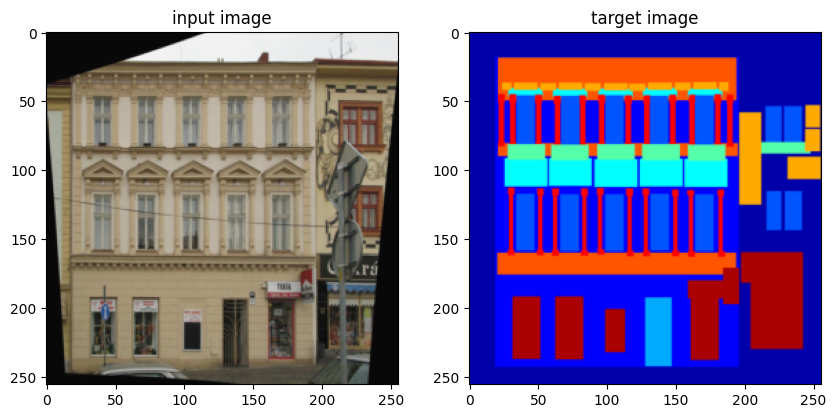

In [102]:
display_samples(train_loader, number=3)

In [103]:
generator = get_generator()

U-Net Generator defined and moved to GPU


In [104]:
discriminator = get_discriminator()

PatchGAN Discriminator defined and moved to GPU


In [105]:
apply_weigts_init(generator, discriminator, weights_init)

Weights initialized with normal distribution (mean=0, std=0.02) for Conv layers and (mean=1, std=0.02) for BatchNorm


In [106]:
criterion_GAN = get_BCEWithLogitsLoss()
criterion_L1 = get_L1Loss()

Loss functions defined: BCEWithLogitsLoss for GAN
Loss functions defined: L1Loss for pixel-wise similarity


In [107]:
optimiser_G = get_optimiser_G()
print (optimiser_G)
optimiser_D = get_optimiser_D()
print (optimiser_D)

Optimizers defined: Adam with lr=0.0002, betas=(0.5, 0.999) for both Generator
<function optimiser_G at 0x7b2e86bfbbe0>
Optimizers defined: Adam with lr=0.0002, betas=(0.5, 0.999) for Discriminator
<function optimiser_D at 0x7b2e86bfbc70>


Generator test output shape: torch.Size([1, 3, 256, 256])


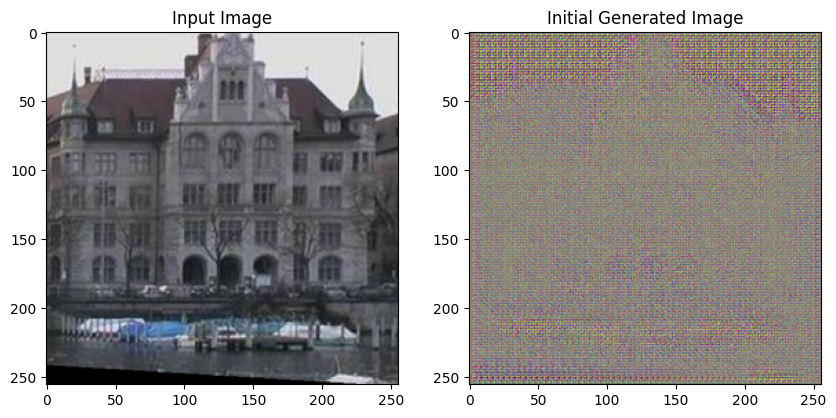

In [108]:
generation_visualisation(train_loader, generator)

In [109]:
num_epochs = 200
lambda_L1 = 100
print(f"Training setup: {num_epochs} epochs, L1 lambda = {lambda_L1}")

Training setup: 200 epochs, L1 lambda = 100


In [110]:
#test for one epoch
model_learning(1, lambda_L1, train_loader, generator, discriminator, optimiser_G, optimiser_D)

1
100
UNetGenerator(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), paddin

AttributeError: 'function' object has no attribute 'zero_grad'

In [ ]:
#full training
model_learning(num_epochs, lambda_L1, train_loader, generator, discriminator, optimiser_G, optimiser_D)

### Testing Procedures

#### Testing data preparation

In [ ]:
### Test data path
# Define test dataset directories (adjust paths if necessary)
test_data_path = data_path + '/cmp_facade_extended'  # Label maps
test_root_dir_A = test_data_path + '/extended'  # Label maps

In [ ]:
# Load test dataset
test_dataset = FacadesDataset(root_dir_A=test_root_dir_A, transform=get_transform())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Test dataset loaded with {len(test_dataset)} samples")

#### Storing the model checkpoints

In [ ]:
torch.save(generator, data_path + "/model.bin")

### Inference Testing

#### data preparation

In [ ]:
# Define inference dataset directories (adjust paths if necessary)
inference_root_dir_A = data_path + '/testNapier'  # Label maps
#test_root_dir_B = data_path + '/testB'  # Real facades

In [ ]:
# Load test dataset
inference_dataset = FacadesInferenceDataset(root_dir_A=inference_root_dir_A, transform=transform)
inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False)
print(f"Test dataset loaded with {len(inference_dataset)} samples")